In [1]:
"""Fit Non-Stationary GEV models with linear trend in parameters and relaxed shape parameter"""


import sys
import os
import argparse
import numpy as np
import pandas as pd
import scipy
import pickle
#import dill

from stats.math_functions import LinearExpr
from stats.stats_utils import neg_log_likelihood
from stats.stats_tests import Test_LikelihoodRatio
from stats import VarDistribution, FitDist

from scipy.stats import genextreme as gev
from matplotlib.lines import Line2D

### CST ###

sl_init = 10**-2


### FUNC ###

def get_vdistr_norm(model, params, covar):
    """generate a variable distribution"""
    assert isinstance(params, dict), 'parameters must be stored in dict'

    loc = params['loc']
    scale = params['scale']
    c = params['c']

    assert len(loc) == 2 or len(scale) == 2, 'at least one of the parameters must be [slope, intercept] shaped for NS distribution'

    if len(loc) == 2:
        loc_sl = loc[0]
        loc_int = loc[1]
        loc_expr = LinearExpr([loc_sl, loc_int])
    else:
        loc_expr = loc[0]

    if len(scale) == 2:
        scale_sl = scale[0]
        scale_int = scale[1]
        scale_expr = LinearExpr([scale_sl, scale_int])
    else:
        scale_expr = scale[0]

    # normalize covariate
    covar_norm = (covar - np.nanmin(covar)) / (np.nanmax(covar) - np.nanmin(covar))

    inds = np.arange(0, len(covar))

    vdistr = VarDistribution(model, loc=loc_expr, scale=scale_expr, c=c)

    x = pd.DataFrame({"x": covar_norm})
    x.index = covar_norm

    output = vdistr(x)

    output.index = inds

    return output


def compute_nsgev_nllh_m10_freexi_norm(params, model, am_sta):
    """compute the nllh of a non-stationary distribution with time-varying parameters"""
    loc = [params[0], params[1]]
    scale = [params[2]]
    c = params[3]

    params_ = {'loc': loc, 'scale': scale, 'c': c}

    years = am_sta.index
    years_ = years[~years.duplicated()]

    vdistr = get_vdistr_norm(model, params_, years_)

    probs_yrs = []

    for iy, distr in vdistr.items():
        probs = distr.pdf(am_sta.loc[years_[iy]])
        probs = np.asarray([probs])
        probs = probs.flatten()
        probs_yrs.append(probs)

    probs_yrs = np.asarray(probs_yrs)

    ps = np.concatenate(probs_yrs)

    nllhs_ns = neg_log_likelihood(ps)

    return nllhs_ns


def compute_nsgev_nllh_m01_freexi_norm(params, model, am_sta):
    """compute the nllh of a non-stationary distribution with time-varying parameters"""
    loc = [params[0]]
    scale = [params[1], params[2]]
    c = params[3]

    params_ = {'loc': loc, 'scale': scale, 'c': c}

    years = am_sta.index
    years_ = years[~years.duplicated()]

    vdistr = get_vdistr_norm(model, params_, years_)

    probs_yrs = []

    for iy, distr in vdistr.items():
        probs = distr.pdf(am_sta.loc[years_[iy]])
        probs = np.asarray([probs])
        probs = probs.flatten()
        probs_yrs.append(probs)

    probs_yrs = np.asarray(probs_yrs)

    ps = np.concatenate(probs_yrs)

    nllhs_ns = neg_log_likelihood(ps)

    return nllhs_ns


def compute_nsgev_nllh_m11_freexi_norm(params, model, am_sta):
    """compute the nllh of a non-stationary distribution with time-varying parameters"""
    loc = [params[0], params[1]]
    scale = [params[2], params[3]]
    c = params[4]

    params_ = {'loc': loc, 'scale': scale, 'c': c}

    years = am_sta.index
    years_ = years[~years.duplicated()]

    vdistr = get_vdistr_norm(model, params_, years_)

    probs_yrs = []

    for iy, distr in vdistr.items():
        probs = distr.pdf(am_sta.loc[years_[iy]])
        probs = np.asarray([probs])
        probs = probs.flatten()
        probs_yrs.append(probs)

    probs_yrs = np.asarray(probs_yrs)

    ps = np.concatenate(probs_yrs)

    nllhs_ns = neg_log_likelihood(ps)

    return nllhs_ns


def minimize_nsgev_nllh_freexi_norm(params, model, am_sta):
    """minimize the nllh with time-dependent gev parameters"""
    loc = params['loc']
    scale = params['scale']
    c = params['c']

    if len(loc) == 2 and len(scale) == 1:
        nllh_func = compute_nsgev_nllh_m10_freexi_norm

    elif len(loc) == 1 and len(scale) == 2:
        nllh_func = compute_nsgev_nllh_m01_freexi_norm

    elif len(loc) == 2 and len(scale) == 2:
        nllh_func = compute_nsgev_nllh_m11_freexi_norm

    else:
        print('loc and/or scale must be non-stationary')

    paraminit = list(loc) + list(scale) + list(c)

    output = scipy.optimize.minimize(nllh_func, x0=paraminit, args=(model, am_sta), method='Nelder-Mead')

    return output


#def load_nsgev_params_freexi_norm(params=['loc', 'scale']):
    """load fitted NS GEV parameters"""

Cannot import rpy2
CANNOT IMPORT ISMEVs
R sink error


In [5]:
def nsgev(am_test,printing=True):
    parser = argparse.ArgumentParser(description = '')
    parser.add_argument("--params", nargs="+", help='params to be tested for non-stationary', type=str, default=['loc', 'scale'])
    parser.add_argument("--model", help='AM distribution model', type=str, default="gev")
    parser.add_argument("--dist_method", help='distribution fit method', type=str, default="mle")

    opts = parser.parse_args(args=[])

    params = opts.params
    model = opts.model
    dist_method = opts.dist_method
    if printing: print('NS parameters to consider: {0}'.format(params))
    
    #~ Get data

    #am = REAL AMAX TIME SERIES AS INPUT
    am = pd.Series(am_test)
    am = am.sort_index()

    years = am.index

    #am = Sample(am)

    #~ Fit S-GEV distribution: get first guess parameter values

    dfit = FitDist(am, model=model, method=dist_method)

    sdist = dfit.distribution
    sparams = sdist.params()
    sloc = sparams['loc']
    sscale = sparams['scale']
    sc = sparams['c']

    nllhs_s = dfit.nllh()

    if printing: print('S-GEV nllh: {0}'.format(nllhs_s))

    """sloc = am.mean()
    sscale = am.std()
    sc = -0.01"""


    #~ Fit NS-GEV model

    fg_params = {}

    if 'loc' in params:
        loc_ = [sl_init, sloc]
    else:
        loc_ = [sloc]

    if 'scale' in params:
        scale_ = [sl_init, sscale]
    else:
        scale_ = [sscale]

    c_ = [sc]

    fg_params = {'loc':loc_, 'scale':scale_, 'c': c_}

    if printing: print('First guess: {0}'.format(fg_params))


    if printing: print('Minimizing nllh...')

    optim = minimize_nsgev_nllh_freexi_norm(params=fg_params, model=model, am_sta=am)


    #~ Treat optim outputs

    res = optim.success
    nllhs_ns = optim.fun
    optim_pars = optim.x

    if ('loc' in params) and ('scale' not in params):

        c_val = [optim_pars[3]]

        if res == True and -1 <= c_val[0] <= 1:
            nllh_val = nllhs_ns
            loc_vals = [optim_pars[0], optim_pars[1]]
            scale_vals = [optim_pars[2]]

        else:
            res = False
            nllh_val = nllhs_s
            loc_vals = [np.nan]
            scale_vals = [np.nan]
            c_val = [np.nan]

    elif ('loc' not in params) and ('scale' in params):

        c_val = [optim_pars[3]]

        if res == True and -1 <= c_val[0] <= 1:
            nllh_val = nllhs_ns
            loc_vals = [optim_pars[0]]
            scale_vals = [optim_pars[1], optim_pars[2]]

        else:
            res = False
            nllh_val = nllhs_s
            loc_vals = [np.nan]
            scale_vals = [np.nan]
            c_val = [np.nan]

    elif ('loc' in params) and ('scale' in params):

        c_val = [optim_pars[4]]

        if res == True and -1 <= c_val[0] <= 1:
            nllh_val = nllhs_ns
            loc_vals = [optim_pars[0], optim_pars[1]]
            scale_vals = [optim_pars[2], optim_pars[3]]

        else:
            res = False
            nllh_val = nllhs_s
            loc_vals = [np.nan]
            scale_vals = [np.nan]
            c_val = [np.nan]

    out_optim = {'succes': res, 'nllh': nllh_val, 'loc': loc_vals, 'scale': scale_vals, 'c': c_val}

    if printing: print('output: {0}'.format(out_optim))



    #~ Test significance

    if printing: print(Test_LikelihoodRatio(null_loglik=-nllhs_s, alt_loglik=-nllh_val, df_diff=1))

    return loc_vals,scale_vals,c_val

NS parameters to consider: ['loc', 'scale']
S-GEV nllh: 311.309840154274
First guess: {'loc': [0.01, 108.40853155191809], 'scale': [0.01, 5.844957352038177], 'c': [0.42511077821984133]}
Minimizing nllh...
output: {'succes': True, 'nllh': 310.51185200612895, 'loc': [0.1537328483869979, 108.36285123093094], 'scale': [-1.5376209231565896, 6.61363883084206], 'c': [0.43347515981379403]}
                        LIKELIHOOD RATIO TEST                         

Infos test : Likelihood comparison of two models: M0 is a particular case of M1

                              HYPOTHESIS                              
Test the null hypothesis    :    H0= M0 (embeded in M1) is true
                                  VS                                  
The alternative hypothesis  :    H1= alternative model M1 is True

                                RESULT                                
Test statistic        :      1.5959762962901323
Associated P VALUE    :      0.2064743615667477
The test              

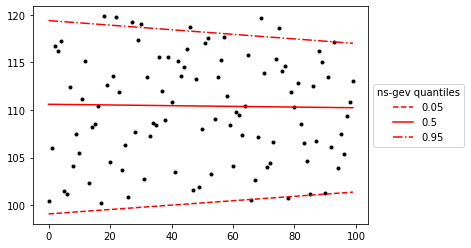

In [4]:
n = 100
years = np.arange(n)
am = np.random.rand(n) * 20 + 100    # values without trend (or random trend)
loc_vals,scale_vals,c_val = nsgev(am)

values = [0.95,0.5,0.05]
lines = ['-.','-','--']

plt.plot(years,am,'.k')
for p,perc in enumerate(values):
    plt.plot(years,gev.ppf(perc, c_val[0], loc=loc_vals[1]+years/n*loc_vals[0], scale=scale_vals[1]+years/n*scale_vals[0]),lines[p]+'r',label=str(perc))
plt.legend(title="ns-gev quantiles",loc='center left', bbox_to_anchor=(1, 0.5))
# am = gev.rvs(c_val[0], loc=loc_vals[1]+years/n*loc_vals[0], scale=scale_vals[1]+years/n*scale_vals[0]) 
# plt.plot(years,am,'.r')

NS parameters to consider: ['loc', 'scale']
S-GEV nllh: 352.730467461206
First guess: {'loc': [0.01, 95.62751776508352], 'scale': [0.01, 7.307857767154093], 'c': [0.07190233652098407]}
Minimizing nllh...
output: {'succes': True, 'nllh': 344.33093216665213, 'loc': [-10.385199929587401, 101.10444165052613], 'scale': [-1.2759583761479178, 7.348631504105127], 'c': [0.07255416272778858]}
                        LIKELIHOOD RATIO TEST                         

Infos test : Likelihood comparison of two models: M0 is a particular case of M1

                              HYPOTHESIS                              
Test the null hypothesis    :    H0= M0 (embeded in M1) is true
                                  VS                                  
The alternative hypothesis  :    H1= alternative model M1 is True

                                RESULT                                
Test statistic        :      16.799070589107714
Associated P VALUE    :      4.1553649682724014e-05
The test         

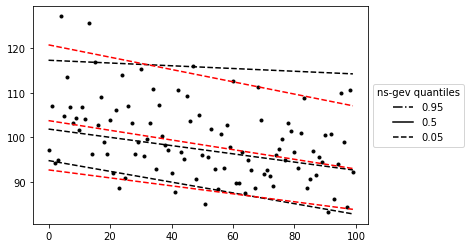

In [13]:
n = 100
years = np.arange(n)

c_val = [-0.1]
loc_vals = [-10,100]
scale_vals = [2,5]
am = gev.rvs(c_val[0], loc=loc_vals[1]+years/n*loc_vals[0], scale=scale_vals[1]+years/n*scale_vals[0]) 

plt.plot(years,am,'.k')
for perc in [0.05,0.5,0.95]:
    plt.plot(years,gev.ppf(perc, c_val[0], loc=loc_vals[1]+years/n*loc_vals[0], scale=scale_vals[1]+years/n*scale_vals[0]),'--k')
    
loc_vals,scale_vals,c_val = nsgev(am)
for perc in [0.05,0.5,0.95]:
    plt.plot(years,gev.ppf(perc, c_val[0], loc=loc_vals[1]+years/n*loc_vals[0], scale=scale_vals[1]+years/n*scale_vals[0]),'--r')
    
quantile_legend = {'handles':[Line2D([0], [0], color='k',ls='-.', lw=1.5, label='0.95'),
Line2D([0], [0], color='k',ls='-', lw=1.5, label='0.5'),
Line2D([0], [0], color='k',ls='--', lw=1.5, label='0.05')],
           'title':"ns-gev quantiles",'loc':'center left', 'bbox_to_anchor':(1, 0.5)}
plt.legend(**quantile_legend)

In [3]:
models = ['MAR_ERA20C','MAR_ERA5','MAR_MPI','MAR_ECearth3','APGD']
#i = 52 ; j = 52 # Grenoble
i = 78 ; j = 63 # lac de garde
#saved_gev = np.load('/home/philinat/Stage-M2/saved_nsgev/saved_gev.npy')
saved_gev = np.zeros((4,5,5))
for season in range(4):
    print('\n'+str(season),end='--')
    for m,model in enumerate(models):
        print(m,end=' ')
        maxs = np.load('/home/philinat/Stage-M2/saved_data_'+model+'/les_season_max.npy')[:,season,j,i]
        loc_vals,scale_vals,c_val = nsgev(maxs,printing=False)
        saved_gev[season,m] = [loc_vals[0],loc_vals[1],scale_vals[0],scale_vals[1],c_val[0]]
        np.save('/home/philinat/Stage-M2/saved_nsgev/saved_gev.npy',saved_gev)


0--0 

NameError: name 'nsgev' is not defined

In [2]:
#saved_gev = np.load('/home/philinat/Stage-M2/saved_nsgev/saved_gev_grenoble.npy')
saved_gev = np.load('/home/philinat/Stage-M2/saved_nsgev/saved_gev.npy')
print(saved_gev)

[[[ 2.13731481e-01  2.38617467e+01 -3.44073462e+00  8.45104107e+00
    3.64405407e-02]
  [ 6.15763452e-01  2.46067964e+01  1.58589159e-01  6.57310279e+00
    2.37323763e-01]
  [ 5.15687567e-02  2.16650533e+01  9.10953885e-01  6.97269980e+00
    1.01986270e-03]
  [ 3.46290469e+00  2.10753671e+01  2.04485658e+00  6.40458035e+00
   -5.25747591e-02]
  [-4.79942662e+00  2.76798069e+01 -8.40410101e+00  1.00907825e+01
   -4.16178843e-01]]

 [[ 8.89785111e-01  2.35190865e+01 -2.95472756e+00  9.26302468e+00
   -8.31976756e-02]
  [ 1.11106380e+00  2.39674367e+01  7.58907770e-01  5.54540677e+00
   -1.49698472e-01]
  [ 2.13584500e+00  2.30257346e+01  2.61211922e+00  6.68187338e+00
   -2.54856494e-02]
  [ 1.16139797e+00  2.35805368e+01  1.73285692e+00  7.02668983e+00
   -7.96192436e-02]
  [ 5.65258609e+00  2.53866158e+01  3.70707856e+00  7.82660527e+00
    1.27681394e-01]]

 [[-4.37820915e-02  1.81987772e+01  4.32056150e-01  6.78227532e+00
   -1.18477733e-01]
  [-3.88250636e+00  3.11812395e+01 -4.3

0 1 2 3 

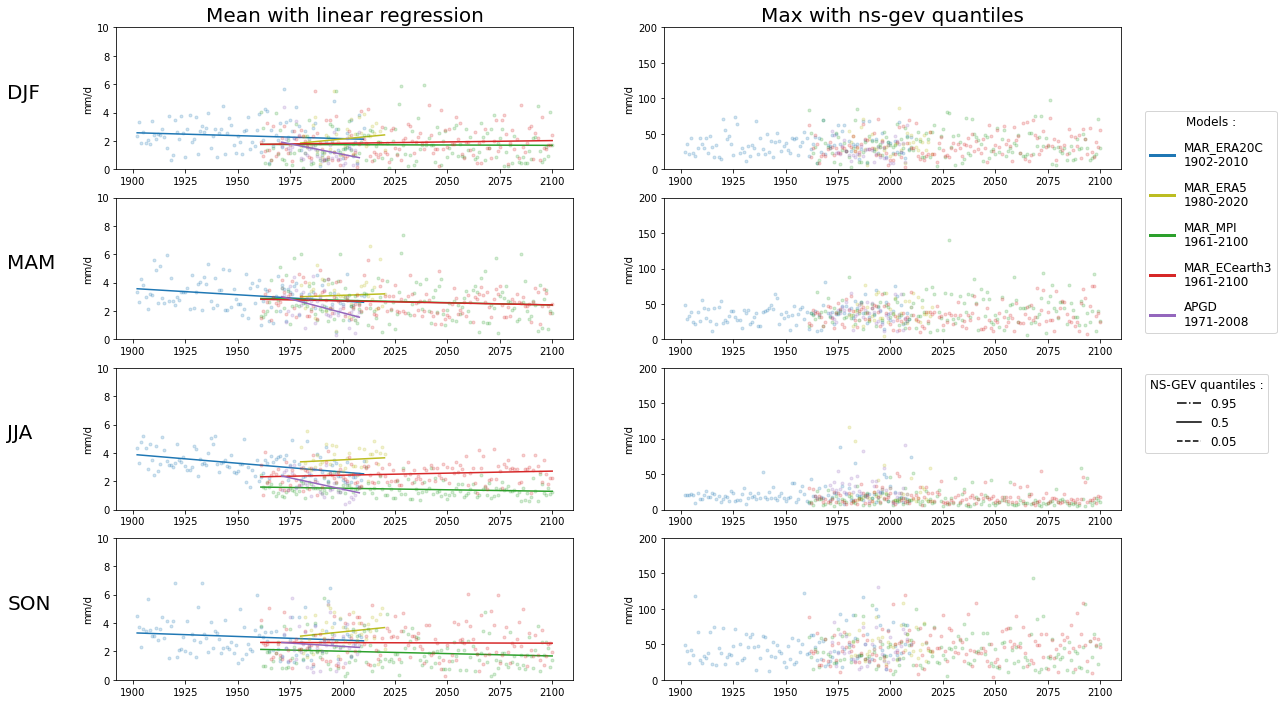

In [2]:
colors = ['#1f77b4','#bcbd22', '#2ca02c', '#d62728', '#9467bd',  '#ff7f0e', '#17becf']
alpha_dots = 0.2

#i = 52 ; j = 52 # Grenoble
#mean_range = [0,5]; max_range = [0,100]

i = 78 ; j = 45 # po
mean_range = [0,10]; max_range = [0,200]

timelines = np.array([[1902,2010],[1980,2020],[1961,2100],[1961,2100],[1971,2008]])
models = ['MAR_ERA20C','MAR_ERA5','MAR_MPI','MAR_ECearth3','APGD']

models_legend = {'handles':[ Line2D([0], [0], color=colors[m],ls='-', lw=3, label=model+'\n'+str(timelines[m,0])+'-'+str(timelines[m,1])) for m,model in enumerate(models)],
           'title':"Models :",'loc':'lower left', 'bbox_to_anchor':(1.04, 0.),'labelspacing':1}

quantile_legend = {'handles':[Line2D([0], [0], color='k',ls='-.', lw=1.5, label='0.95'),
Line2D([0], [0], color='k',ls='-', lw=1.5, label='0.5'),
Line2D([0], [0], color='k',ls='--', lw=1.5, label='0.05')],
           'title':"NS-GEV quantiles :",'loc':'upper left', 'bbox_to_anchor':(1.04, 1)}

f, axs = plt.subplots(nrows=4,ncols=2,figsize=(18,12))
for season in range(4):
    print(season,end=' ')
    # titles
    if season==0:
        axs[season,0].set_title("Mean with linear regression",fontsize=20)
        axs[season,1].set_title("Max with ns-gev quantiles",fontsize=20)
    axs[season,0].text(1840,mean_range[1]/2,['DJF','MAM','JJA', 'SON'][season],fontsize=20)
    
    axs[season,0].set_ylim(mean_range) ; axs[season,0].set_ylabel('mm/d')
    axs[season,1].set_ylim(max_range) ; axs[season,1].set_ylabel('mm/d')
    
    for m,model in enumerate(models):
        t = np.arange(timelines[m,0],timelines[m,1]+1,1)
        x= np.linspace(np.min(t),np.max(t),2)
        
        means = np.load('/home/philinat/Stage-M2/saved_data_'+model+'/les_season_mean.npy')[:,season,j,i]
        maxs = np.load('/home/philinat/Stage-M2/saved_data_'+model+'/les_season_max.npy')[:,season,j,i]
        
        # Linear regression for mean trends
        axs[season,0].plot(t,means,'.',label=model,alpha=alpha_dots,color=colors[m])
        a, b = np.polyfit(t, means, 1)
        axs[season,0].plot(x, a*x + b,color=colors[m])
        
        # nsgev quantiles for max trends
        axs[season,1].plot(t,maxs,'.',label=model,alpha=alpha_dots,color=colors[m])
        
        # s = saved_gev[season,m]
        # loc_vals = [s[0],s[1]]
        # scale_vals = [s[2],s[3]]
        # c_val = [s[4]]
        # # loc_vals,scale_vals,c_val = nsgev(maxs,printing=False)
        # for p,perc in enumerate([0.95,0.05,0.5]):
        #     axs[season,1].plot(x,gev.ppf(perc, c_val[0], loc=loc_vals[1]+(x-x[0])/len(t)*loc_vals[0], scale=scale_vals[1]+(x-x[0])/len(t)*scale_vals[0]),ls=['-.','-','--'][p],color=colors[m])
    
        
axs[1,1].legend(**models_legend,fontsize='large',title_fontsize='large')
axs[2,1].legend(**quantile_legend,fontsize='large',title_fontsize='large')